# Vertex AI: Qwik Start

## Learning objectives

* Train a TensorFlow model locally in a hosted [**Vertex Notebook**](https://cloud.google.com/vertex-ai/docs/general/notebooks?hl=sv).
* Create a [**managed Tabular dataset**](https://cloud.google.com/vertex-ai/docs/training/using-managed-datasets?hl=sv) artifact for experiment tracking.
* Containerize your training code with [**Cloud Build**](https://cloud.google.com/build) and push it to [**Google Cloud Artifact Registry**](https://cloud.google.com/artifact-registry).
* Run a [**Vertex AI custom training job**](https://cloud.google.com/vertex-ai/docs/training/custom-training) with your custom model container.
* Use [**Vertex TensorBoard**](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) to visualize model performance.
* Deploy your trained model to a [**Vertex Online Prediction Endpoint**](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) for serving predictions.
* Request an online prediction and explanation and see the response.

## Introduction: customer lifetime value (CLV) prediction with BigQuery and TensorFlow on Vertex AI

In this lab, you will use [BigQuery](https://cloud.google.com/bigquery) for data processing and exploratory data analysis and the [Vertex AI](https://cloud.google.com/vertex-ai) platform to train and deploy a custom TensorFlow Regressor model to predict customer lifetime value (CLV). The goal of the lab is to introduce to Vertex AI through a high value real world use case - predictive CLV. You will start with a local BigQuery and TensorFlow workflow that you may already be familiar with and progress toward training and deploying your model in the cloud with Vertex AI.

![Vertex AI](./images/vertex-ai-overview.png "Vertex AI Overview")

Vertex AI is Google Cloud's next generation, unified platform for machine learning development and the successor to AI Platform announced at Google I/O in May 2021. By developing machine learning solutions on Vertex AI, you can leverage the latest ML pre-built components and AutoML to significantly enhance development productivity, the ability to scale your workflow and decision making with your data, and accelerate time to value.

### Predictive CLV: how much monetary value existing customers will bring to the business in the future

Predictive CLV is a high impact ML business use case. CLV is a customer's past value plus their predicted future value. The goal of predictive CLV is to predict how much monetary value a user will bring to the business in a defined future time range based on historical transactions.

By knowing CLV, you can develop positive ROI strategies and make decisions about how much money to invest in acquiring new customers and retaining existing ones to grow revenue and profit.

Once your ML model is a success, you can use the results to identify customers more likely to spend money than the others, and make them respond to your offers and discounts with a greater frequency. These customers, with higher lifetime value, are your main marketing target to increase revenue.

By using the machine learning approach to predict your customers' value you will use in this lab, you can prioritize your next actions, such as the following:

* Decide which customers to target with advertising to increase revenue.
* Identify which customer segments are most profitable and plan how to move customers from one segment to another.

Your task is to predict the future value for existing customers based on their known transaction history. 

![CLV](./images/clv-rfm.svg "Customer Lifetime Value")  
Source: [Cloud Architecture Center - Predicting Customer Lifetime Value with AI Platform: training the models](https://cloud.google.com/architecture/clv-prediction-with-offline-training-train)

There is a strong positive correlation between the recency, frequency, and amount of money spent on each purchase each customer makes and their CLV. Consequently, you will leverage these features to in your ML model. For this lab, they are defined as:

* **Recency**: The time between the last purchase and today, represented by the distance between the rightmost circle and the vertical dotted line that's labeled "Now".
* **Frequency**: The time between purchases, represented by the distance between the circles on a single line.
* **Monetary**: The amount of money spent on each purchase, represented by the size of the circle. This amount could be the average order value or the quantity of products that the customer ordered.

## Setup

### Define constants

In [1]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

In [3]:
# Create a globally unique Google Cloud Storage bucket for artifact storage.
GCS_BUCKET = f"{PROJECT_ID}-bucket"

[google-cloud storage command-line tool](https://cloud.google.com/storage/docs/gsutil/commands/mb), used to make buckets(mb) , with location(-l) , and given bucket-name-path

In [4]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://qwiklabs-gcp-02-72bc2c207063-bucket/...


### Import libraries

In [5]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.cloud import aiplatform

### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [6]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## Download and process the lab data into BigQuery

### Dataset

In this lab, you will use the publicly available [Online Retail data set](https://archive.ics.uci.edu/ml/datasets/online+retail) from the UCI Machine Learning Repository. This dataset contains 541,909 transnational customer transactions occuring between (YYYY-MM-DD) 2010-12-01 and 2011-12-09 for a UK-based and registered non-store retailer. The company primarily sells unique all-occasion gifts. Many of the company's customers are wholesalers.

**Citation**  
Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

This lab is also inspired by the Google Cloud Architect Guide Series [Predicting Customer Lifetime Value with AI Platform: introduction](https://cloud.google.com/architecture/clv-prediction-with-offline-training-intro).

### Data ingestion

Execute the command below to ingest the lab data from the UCI Machine Learning repository into `Cloud Storage` and then upload to `BigQuery` for data processing. The data ingestion and processing scripts are available under the `utils` folder in the lab directory.

In [7]:
# BigQuery constants. Please leave these unchanged.
BQ_DATASET_NAME="online_retail"
BQ_RAW_TABLE_NAME="online_retail_clv_raw"
BQ_CLEAN_TABLE_NAME="online_retail_clv_clean"
BQ_ML_TABLE_NAME="online_retail_clv_ml"
BQ_URI=f"bq://{PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_ML_TABLE_NAME}"

**Note**: this Python script will take about 2-3 min to download and process the lab data file. Follow along with logging output in the cell below.

<font color="red">TO CHECK:</font> **`utils.data_download.py`**
- this scripts downloads the xls file, converts it to csv
- then stores it into GCS bucket
- creates a BQ table out of this csv-in-GCS-bucket.
- this procedure is done for the raw, cleansed and ML dataset.

In [8]:
!python utils/data_download.py \
  --PROJECT_ID={PROJECT_ID} \
  --GCS_BUCKET={GCS_BUCKET} \
  --BQ_RAW_TABLE_NAME={BQ_RAW_TABLE_NAME} \
  --BQ_CLEAN_TABLE_NAME={BQ_CLEAN_TABLE_NAME} \
  --BQ_ML_TABLE_NAME={BQ_ML_TABLE_NAME} \
  --URL="https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online Retail.xlsx"


 2022-01-17 17:21:08,025 [INFO] Downloading xlsx file...
100% [....................................................] 23715344 / 23715344
 2022-01-17 17:21:09,153 [INFO] Converting xlsx -> csv...

 2022-01-17 17:22:12,049 [INFO] Uploading local csv file to GCS...

 2022-01-17 17:22:12,557 [INFO] Copied local csv file to GCS.

 2022-01-17 17:22:12,567 [INFO] Cleaning up local tmp data directory...

 2022-01-17 17:22:12,599 [INFO] Initializing BigQuery dataset.

 2022-01-17 17:22:13,055 [INFO] Created dataset qwiklabs-gcp-02-72bc2c207063.online_retail

 2022-01-17 17:22:13,864 [INFO] BQ raw dataset load job starting...

 2022-01-17 17:22:22,080 [INFO] BQ raw dataset load job complete.

 2022-01-17 17:22:22,227 [INFO] Loaded 541909 rows into qwiklabs-gcp-02-72bc2c207063.online_retail.online_retail_clv_raw.

 2022-01-17 17:22:22,234 [INFO] BQ make clean dataset starting...

 2022-01-17 17:22:26,200 [INFO] BQ make clean dataset complete

 2022-01-17 17:22:26,330 [INFO] Loaded 16766 rows int

### Data processing

As is the case with many real-world datasets, the lab dataset required some cleanup for you to utilize this historical customer transaction data for predictive CLV.

The following changes were applied:

* Keep only records that have a Customer ID.
* Aggregate transactions by day from Invoices. <font color="red">check the aggregation level!!</font>
* Keep only records that have positive order quantities and monetary values.
* Aggregate transactions by Customer ID and compute recency, frequency, monetary features as well as the prediction target.

**Features**:
- `customer_country` (CATEGORICAL): customer purchase country.
- `n_purchases` (NUMERIC): number of purchases made in feature window. (frequency)
- `avg_purchase_size` (NUMERIC): average unit purchase count in feature window. (monetary)
- `avg_purchase_revenue` (NUMERIC): average GBP purchase amount in in feature window. (monetary)
- `customer_age` (NUMERIC): days from first purchase in feature window.
- `days_since_last_purchase` (NUMERIC): days from the most recent purchase in the feature window. (recency)  

**Target**: 
- `target_monetary_value_3M` (NUMERIC): customer revenue from the entire study window including feature and prediction windows.

Note: this lab demonstrates a simple way to use a DNN predict customer 3-month ahead CLV monetary value based solely on the available dataset historical transaction history. Additional factors to consider in practice when using CLV to inform interventions include customer acquisition costs, profit margins, and discount rates to arrive at the present value of future customer cash flows. One of a DNN's benefits over traditional probabilistic modeling approaches is their ability to incorporate additional categorical and unstructured features; this is a great feature engineering opportunity to explore beyond this lab which just explores the RFM(recency, frequency, and monetary) numeric features.

## Exploratory data analysis (EDA) in BigQuery

Below you will use BigQuery from this notebook to do exploratory data analysis to get to know this dataset and identify opportunities for data cleanup and feature engineering.

### Recency: how recently have customers purchased?

In [9]:
%%bigquery recency

SELECT 
  days_since_last_purchase
FROM 
  `online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2952.38rows/s]


- didn't have to put any credentials or client.query(), is this because this is a <font color="red">vertex notebook opened directly in the project??</font>

In [10]:
recency.describe()

,days_since_last_purchase
count,3330.000000
mean,92.521021
std,77.240666
min,0.000000
25%,27.000000
50%,73.000000
75%,146.750000
max,274.000000


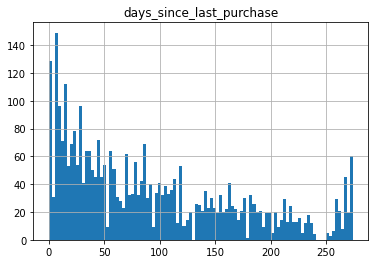

In [11]:
recency.hist(bins=100);

From the chart, there are clearly a few different customer groups here such as loyal customers that have made purchases in the last few days as well as inactive customers that have not purchased in 250+ days. Using CLV predictions and insights, you can strategize on marketing and promotional interventions to improve customer purchase recency and re-active dormant customers.

### Frequency: how often are customers purchasing?

In [12]:
%%bigquery frequency

SELECT
  n_purchases
FROM
  `online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2534.66rows/s]


In [13]:
frequency.describe()

,n_purchases
count,3330.000000
mean,3.134234
std,4.504362
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,81.000000


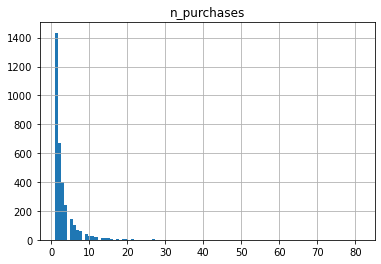

In [14]:
frequency.hist(bins=100);

From the chart and quantiles, you can see that half of the customers have less than or equal to only 2 purchases. You can also tell from the average purchases > median purchases and max purchases of 81 that there are customers, likely wholesalers, who have made significantly more purchases. This should have you already thinking about feature engineering opportunities such as bucketizing purchases and removing or clipping outlier customers. You can also explore alternative modeling strategies for CLV on new customers who have only made 1 purchase as the approach demonstrated in this lab will perform better on customers with more relationship transactional history. 

### Monetary: how much are customers spending?

In [15]:
%%bigquery monetary

SELECT
  target_monetary_value_3M
FROM
`online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2606.30rows/s]


In [16]:
monetary.describe()

,target_monetary_value_3M
count,3330.000000
mean,2355.838718
std,9445.870149
min,2.900000
25%,346.695000
50%,826.525000
75%,1977.495000
max,268478.000000


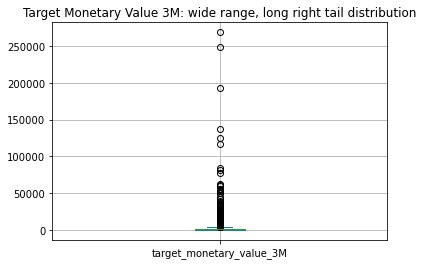

In [17]:
monetary['target_monetary_value_3M'].plot(kind='box', title="Target Monetary Value 3M: wide range, long right tail distribution", grid=True);

<font color="red">side-note:</font> so `describe()`, `.hist()` and `.plot(kind="box")` are always important.

From the chart and summary statistics, you can see there is a wide range in customer monetary value ranging from 2.90 to 268,478 GBP. Looking at the quantiles, it is clear there are a few outlier customers whose monetary value is greater than 3 standard deviations from the mean. With this small dataset, it is recommended to remove these outlier customer values to treat separately, change your model's loss function to be more resistant to outliers, log the target feature, or clip their values to a maximum threshold. You should also be revisiting your CLV business requirements to see if binning customer monetary value and reframing this as a ML classification problem would suit your needs.

### Establish a simple model performance baseline

In order to evaluate the performance of your custom TensorFlow DNN Regressor model you will build in the next steps, it is a ML best practice to establish a simple performance baseline. Below is a simple SQL baseline that multiplies a customer's average purchase spent compounded by their daily purchase rate and computes standard regression metrics.

In [ ]:
%%bigquery

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `online_retail.online_retail_clv_ml`
  LEFT JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

# Calculate overall baseline regression metrics.
SELECT
  ROUND(AVG(ABS(predicted_monetary_value_3M - target_monetary_value_3M)), 2) AS MAE,
  ROUND(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2)), 2) AS MSE,
  ROUND(SQRT(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2))), 2) AS RMSE
FROM
  predicted_clv

These baseline results provide further support for the strong impact of outliers. The extremely high MSE comes from the exponential penalty applied to missed predictions and the magnitude of error on a few predictions.

Next, you should look to plot the baseline results to get a sense of opportunity areas for you ML model.

In [ ]:
%%bigquery baseline

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `online_retail.online_retail_clv_ml`
  INNER JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
 *
FROM
  predicted_clv

In [ ]:
baseline.head()

In [ ]:
ax = baseline.plot(kind='scatter',
                   x='predicted_monetary_value_3M', 
                   y='target_monetary_value_3M',
                   title='Actual vs. Predicted customer 3-month monetary value',
                   figsize=(5,5),
                   grid=True)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims);

## Train a TensorFlow model locally

Now that you have a simple baseline to benchmark your performance against, train a TensorFlow Regressor to predict CLV.

In [ ]:
%%bigquery

SELECT data_split, COUNT(*)
FROM `online_retail.online_retail_clv_ml`
GROUP BY data_split

In [ ]:
%%bigquery clv

SELECT *
FROM `online_retail.online_retail_clv_ml`

In [ ]:
clv_train = clv.loc[clv.data_split == 'TRAIN', :]
clv_dev = clv.loc[clv.data_split == 'VALIDATE', :]
clv_test = clv.loc[clv.data_split == 'TEST', :]

In [ ]:
# Model training constants.
# Virtual epochs design pattern:
# https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
N_TRAIN_EXAMPLES = 2638
STOP_POINT = 20.0
TOTAL_TRAIN_EXAMPLES = int(STOP_POINT * N_TRAIN_EXAMPLES)
BATCH_SIZE = 32
N_CHECKPOINTS = 10
STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (BATCH_SIZE*N_CHECKPOINTS))

NUMERIC_FEATURES = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
]

LABEL = "target_monetary_value_3M"

In [ ]:
def df_dataset(df):
    """Transform Pandas Dataframe to TensorFlow Dataset."""
    return tf.data.Dataset.from_tensor_slices((df[NUMERIC_FEATURES].to_dict('list'), df[LABEL].values))

In [ ]:
trainds = df_dataset(clv_train).prefetch(1).batch(BATCH_SIZE).repeat()
devds = df_dataset(clv_dev).prefetch(1).batch(BATCH_SIZE)
testds = df_dataset(clv_test).prefetch(1).batch(BATCH_SIZE)

In [ ]:
def rmse(y_true, y_pred):
    """Custom RMSE regression metric."""
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model():
    """Build and compile a TensorFlow Keras Regressor."""
    # Define input feature tensors and input layers.
    feature_columns = [
        tf.feature_column.numeric_column(key=feature)
        for feature in NUMERIC_FEATURES
    ]
    
    input_layers = {
        feature.key: tf.keras.layers.Input(name=feature.key, shape=(), dtype=tf.float32)
        for feature in feature_columns
    }
     
    # Keras Functional API: https://keras.io/guides/functional_api
    inputs = tf.keras.layers.DenseFeatures(feature_columns, name='inputs')(input_layers)
    d1 = tf.keras.layers.Dense(256, activation=tf.nn.relu, name='d1')(inputs)
    d2 = tf.keras.layers.Dropout(0.2, name='d2')(d1)  
    # Note: the single neuron output for regression.
    output = tf.keras.layers.Dense(1, name='output')(d2)
    
    model = tf.keras.Model(input_layers, output, name='online-retail-clv')
    
    optimizer = tf.keras.optimizers.Adam(0.001)    
    
    # Note: MAE loss is more resistant to outliers than MSE.
    model.compile(loss=tf.keras.losses.MAE,
                  optimizer=optimizer,
                  metrics=[['mae', 'mse', rmse]])
    
    return model

model = build_model()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./local-training/tensorboard',
    histogram_freq=1)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./local-training/checkpoints',
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

In [ ]:
history = model.fit(trainds,
                    validation_data=devds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=N_CHECKPOINTS,
                    callbacks=[[tensorboard_callback,
                                earlystopping_callback,
                                checkpoint_callback]])

In [ ]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot();

In [ ]:
train_pred = model.predict(df_dataset(clv_train).prefetch(1).batch(BATCH_SIZE))
dev_pred = model.predict(devds)
test_pred = model.predict(testds)

In [ ]:
train_results = pd.DataFrame({'actual': clv_train['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(train_pred)}, columns=['actual', 'predicted'])
dev_results = pd.DataFrame({'actual': clv_dev['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(dev_pred)}, columns=['actual', 'predicted'])
test_results = pd.DataFrame({'actual': clv_test['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(test_pred)}, columns=['actual', 'predicted'])

In [ ]:
# Model prediction calibration plots.
fig, (train_ax, dev_ax, test_ax) = plt.subplots(1, 3, figsize=(15,15))

train_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Train: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=train_ax)

train_lims = [
    np.min([train_ax.get_xlim(), train_ax.get_ylim()]),  # min of both axes
    np.max([train_ax.get_xlim(), train_ax.get_ylim()]),  # max of both axes
]

train_ax.plot(train_lims, train_lims, 'k-', alpha=0.5, zorder=0)
train_ax.set_aspect('equal')
train_ax.set_xlim(train_lims)
train_ax.set_ylim(train_lims)

dev_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Dev: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=dev_ax)

dev_lims = [
    np.min([dev_ax.get_xlim(), dev_ax.get_ylim()]),  # min of both axes
    np.max([dev_ax.get_xlim(), dev_ax.get_ylim()]),  # max of both axes
]

dev_ax.plot(dev_lims, dev_lims, 'k-', alpha=0.5, zorder=0)
dev_ax.set_aspect('equal')
dev_ax.set_xlim(dev_lims)
dev_ax.set_ylim(dev_lims)

test_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Test: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=test_ax)

test_lims = [
    np.min([test_ax.get_xlim(), test_ax.get_ylim()]),  # min of both axes
    np.max([test_ax.get_xlim(), test_ax.get_ylim()]),  # max of both axes
]

test_ax.plot(test_lims, test_lims, 'k-', alpha=0.5, zorder=0)
test_ax.set_aspect('equal')
test_ax.set_xlim(test_lims)
test_ax.set_ylim(test_lims);

You have trained a model better than your baseline. As indicated in the charts above, there is still additional feature engineering and data cleaning opportunities to improve your model's performance on customers with CLV. Some options include handling these customers as a separate prediction task, applying a log transformation to your target, clipping their value or dropping these customers all together to improve model performance.

Now you will work through taking this local TensorFlow workflow to the cloud with Vertex AI.

## Create a managed Tabular dataset from your BigQuery data source

[**Vertex AI managed datasets**](https://cloud.google.com/vertex-ai/docs/datasets/prepare-tabular) can be used to train AutoML models or custom-trained models.

You will create a [**Tabular regression dataset**](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular) for managing the sharing and metadata for this lab's dataset stored in BigQuery. Managed datasets enable you to create a clear link between your data and custom-trained models, and provide descriptive statistics and automatic or manual splitting into train, test, and validation sets. 

In this lab, the data processing step already created a manual `data_split` column in our BQ ML table using [BigQuery's hashing functions](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39) for repeatable sampling.

In [ ]:
tabular_dataset = aiplatform.TabularDataset.create(display_name="online-retail-clv", bq_source=f"{BQ_URI}")

## Vertex AI custom ML model training workflow

There are two ways you can train a custom model on Vertex AI:

Before you submit a custom training job, hyperparameter tuning job, or a training pipeline to Vertex AI, you need to create a Python training application or a custom container to define the training code and dependencies you want to run on Vertex AI.

**1. Use a Google Cloud prebuilt container**: if you use a Vertex AI prebuilt container, you will write a Python `task.py` script or Python package to install into the container image that defines your code for training a custom model. See [Creating a Python training application for a pre-built container](https://cloud.google.com/vertex-ai/docs/training/create-python-pre-built-container) for more details on how to structure you Python code. Choose this option if a prebuilt container already contains the model training libraries you need such as `tensorflow` or `xgboost` and you are just doing ML training and prediction quickly. You can also specific additional Python dependencies to install through the `CustomTrainingJob(requirements=...` argument.

**2. Use your own custom container image**: If you want to use your own custom container, you will write your Python training scripts and a Dockerfile that contains instructions on your ML model code, dependencies, and execution instructions. You will build your custom container with Cloud Build, whose instructions are specified in `cloudbuild.yaml` and publish your container to your Artifact Registry. Choose this option if you want to package your ML model code with dependencies together in a container to build toward running as part of a portable and scalable [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) workflow. 

### Containerize your model training code

In the next 5 steps, you will proceed with **2. Use your own custom container image**. 

You will build your custom model container on top of a [Google Cloud Deep Learning container](https://cloud.google.com/vertex-ai/docs/general/deep-learning) that contains tested and optimized versions of model code dependencies such as `tensorflow` and the `google-cloud-bigquery` SDK. This also gives you flexibility and enables to manage and share your model container image with others for reuse and reproducibility across environments while also enabling you to incorporate additional packages for your ML application. Lastly, by packaging your ML model code together with dependencies you also have a MLOps onboarding path to Vertex Pipelines.

You will walk through creating the following project structure for your ML mode code:

```
|--/online-retail-clv-3M
   |--/trainer
      |--__init__.py
      |--model.py
      |--task.py
   |--Dockerfile
   |--cloudbuild.yaml
   |--requirements.txt
```

#### 1. Write a `model.py` training script

First, you will take tidy up your local TensorFlow model training code from above into a training script.

The biggest change is you will utilize the [TensorFlow IO](https://www.tensorflow.org/io/tutorials/bigquery) library to performantly read from BigQuery directly into your TensorFlow model graph during training. This will improve your training performance rather than performing the intermediate step of reading from BigQuery into a Pandas Dataframe done for expediency above.

In [ ]:
# this is the name of your model subdirectory you will write your model code to. It is already created in your lab directory.
MODEL_NAME="online-retail-clv-3M"

In [ ]:
%%writefile {MODEL_NAME}/trainer/model.py
import os
import logging
import tempfile
import tensorflow as tf
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession


# Model feature constants.
NUMERIC_FEATURES = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
]

CATEGORICAL_FEATURES = [
    "customer_country"
]

LABEL = "target_monetary_value_3M"


def caip_uri_to_fields(uri):
    """Helper function to parse BQ URI."""
    # Remove bq:// prefix.
    uri = uri[5:]
    project, dataset, table = uri.split('.')
    return project, dataset, table


def features_and_labels(row_data):
    """Helper feature and label mapping function for tf.data."""
    label = row_data.pop(LABEL)
    features = row_data
    return features, label


def read_bigquery(project, dataset, table):
    """TensorFlow IO BigQuery Reader."""
    tensorflow_io_bigquery_client = BigQueryClient()
    read_session = tensorflow_io_bigquery_client.read_session(
      parent="projects/" + project,
      project_id=project, 
      dataset_id=dataset,
      table_id=table,
      # Pass list of features and label to be selected from BQ.
      selected_fields=NUMERIC_FEATURES + [LABEL],
      # Provide output TensorFlow data types for features and label.
      output_types=[dtypes.int64, dtypes.float64, dtypes.float64, dtypes.int64, dtypes.int64] + [dtypes.float64],
      requested_streams=2)
    dataset = read_session.parallel_read_rows()
    transformed_ds = dataset.map(features_and_labels)
    return transformed_ds


def rmse(y_true, y_pred):
    """Custom RMSE regression metric."""
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model(hparams):
    """Build and compile a TensorFlow Keras DNN Regressor."""

    feature_columns = [
        tf.feature_column.numeric_column(key=feature)
        for feature in NUMERIC_FEATURES
    ]
    
    input_layers = {
        feature.key: tf.keras.layers.Input(name=feature.key, shape=(), dtype=tf.float32)
        for feature in feature_columns
    }
    # Keras Functional API: https://keras.io/guides/functional_api
    inputs = tf.keras.layers.DenseFeatures(feature_columns, name='inputs')(input_layers)
    d1 = tf.keras.layers.Dense(256, activation=tf.nn.relu, name='d1')(inputs)
    d2 = tf.keras.layers.Dropout(hparams['dropout'], name='d2')(d1)    
    # Note: a single neuron scalar output for regression.
    output = tf.keras.layers.Dense(1, name='output')(d2)
    
    model = tf.keras.Model(input_layers, output, name='online-retail-clv')
    
    optimizer = tf.keras.optimizers.Adam(hparams['learning-rate'])    
    
    # Note: MAE loss is more resistant to outliers than MSE.
    model.compile(loss=tf.keras.losses.MAE,
                  optimizer=optimizer,
                  metrics=[['mae', 'mse', rmse]])
    
    return model


def train_evaluate_explain_model(hparams):
    """Train, evaluate, explain TensorFlow Keras DNN Regressor.
    Args:
      hparams(dict): A dictionary containing model training arguments.
    Returns:
      history(tf.keras.callbacks.History): Keras callback that records training event history.
    """
    training_ds = read_bigquery(*caip_uri_to_fields(hparams['training-data-uri'])).prefetch(1).shuffle(hparams['batch-size']*10).batch(hparams['batch-size']).repeat()
    eval_ds = read_bigquery(*caip_uri_to_fields(hparams['validation-data-uri'])).prefetch(1).shuffle(hparams['batch-size']*10).batch(hparams['batch-size'])
    test_ds = read_bigquery(*caip_uri_to_fields(hparams['test-data-uri'])).prefetch(1).shuffle(hparams['batch-size']*10).batch(hparams['batch-size'])
    
    model = build_model(hparams)
    logging.info(model.summary())
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=hparams['tensorboard-dir'],
        histogram_freq=1)
    
    # Reduce overfitting and shorten training times.
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)
    
    # Ensure your training job's resilience to VM restarts.
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath= hparams['checkpoint-dir'],
        save_weights_only=True,
        monitor='val_loss',
        mode='min')
    
    # Virtual epochs design pattern:
    # https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
    TOTAL_TRAIN_EXAMPLES = int(hparams['stop-point'] * hparams['n-train-examples'])
    STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (hparams['batch-size']*hparams['n-checkpoints']))    
    
    history = model.fit(training_ds,
                        validation_data=eval_ds,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=hparams['n-checkpoints'],
                        callbacks=[[tensorboard_callback,
                                    earlystopping_callback,
                                    checkpoint_callback]])
    
    logging.info(model.evaluate(test_ds))
    
    # Create a temp directory to save intermediate TF SavedModel prior to Explainable metadata creation.
    tmpdir = tempfile.mkdtemp()
    
    # Export Keras model in TensorFlow SavedModel format.
    model.save(tmpdir)
    
    # Annotate and save TensorFlow SavedModel with Explainable metadata to GCS.
    builder = SavedModelMetadataBuilder(tmpdir)
    builder.save_model_with_metadata(hparams['model-dir'])
    
    return history

#### 2. Write a `task.py` file as an entrypoint to your custom ML model container

In [ ]:
%%writefile {MODEL_NAME}/trainer/task.py
import os
import argparse

from trainer import model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Vertex custom container training args. These are set by Vertex AI during training but can also be overwritten.
    parser.add_argument('--model-dir', dest='model-dir',
                        default=os.environ['AIP_MODEL_DIR'], type=str, help='Model dir.')
    parser.add_argument('--checkpoint-dir', dest='checkpoint-dir',
                        default=os.environ['AIP_CHECKPOINT_DIR'], type=str, help='Checkpoint dir set during Vertex AI training.')    
    parser.add_argument('--tensorboard-dir', dest='tensorboard-dir',
                        default=os.environ['AIP_TENSORBOARD_LOG_DIR'], type=str, help='Tensorboard dir set during Vertex AI training.')    
    parser.add_argument('--data-format', dest='data-format',
                        default=os.environ['AIP_DATA_FORMAT'], type=str, help="Tabular data format set during Vertex AI training. E.g.'csv', 'bigquery'")
    parser.add_argument('--training-data-uri', dest='training-data-uri',
                        default=os.environ['AIP_TRAINING_DATA_URI'], type=str, help='Training data GCS or BQ URI set during Vertex AI training.')
    parser.add_argument('--validation-data-uri', dest='validation-data-uri',
                        default=os.environ['AIP_VALIDATION_DATA_URI'], type=str, help='Validation data GCS or BQ URI set during Vertex AI training.')
    parser.add_argument('--test-data-uri', dest='test-data-uri',
                        default=os.environ['AIP_TEST_DATA_URI'], type=str, help='Test data GCS or BQ URI set during Vertex AI training.')
    # Model training args.
    parser.add_argument('--learning-rate', dest='learning-rate', default=0.001, type=float, help='Learning rate for optimizer.')
    parser.add_argument('--dropout', dest='dropout', default=0.2, type=float, help='Float percentage of DNN nodes [0,1] to drop for regularization.')    
    parser.add_argument('--batch-size', dest='batch-size', default=16, type=int, help='Number of examples during each training iteration.')    
    parser.add_argument('--n-train-examples', dest='n-train-examples', default=2638, type=int, help='Number of examples to train on.')
    parser.add_argument('--stop-point', dest='stop-point', default=10, type=int, help='Number of passes through the dataset during training to achieve convergence.')
    parser.add_argument('--n-checkpoints', dest='n-checkpoints', default=10, type=int, help='Number of model checkpoints to save during training.')
    
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_evaluate_explain_model(hparams)

#### 3. Write a `Dockerfile` for your custom ML model container

Third, you will write a `Dockerfile` that contains your model code as well as specifies your model code's dependencies.

Notice the base image below is a [Google Cloud Deep Learning container](https://cloud.google.com/vertex-ai/docs/general/deep-learning) that contains tested and optimized versions of model code dependencies such as `tensorflow` and the `google-cloud-bigquery` SDK.

In [ ]:
%%writefile {MODEL_NAME}/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/general/deep-learning
# https://cloud.google.com/deep-learning-containers/docs/choosing-container
FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3

# Sets the container working directory.
WORKDIR /root

# Copies the requirements.txt into the container to reduce network calls.
COPY requirements.txt .
# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# Copies the trainer code to the docker image.
COPY . /trainer

# Sets the container working directory.
WORKDIR /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.task"]

### 4. Write a `requirements.txt` file to specify additional ML code dependencies

These are additional dependencies for your model code outside the deep learning containers needed for prediction explainability and the BigQuery TensorFlow IO reader.

In [ ]:
%%writefile {MODEL_NAME}/requirements.txt
explainable-ai-sdk==1.3.0
tensorflow-io==0.15.0
pyarrow

#### 5. Use Cloud Build to build and submit your container to Google Cloud Artifact Registry

Next, you will use [Cloud Build](https://cloud.google.com/build) to build and upload your custom TensorFlow model container to [Google Cloud Artifact Registry](https://cloud.google.com/artifact-registry).

Cloud Build brings reusability and automation to your ML experimentation by enabling you to reliably build, test, and deploy your ML model code as part of a CI/CD workflow. Artifact Registry provides a centralized repository for you to store, manage, and secure your ML container images. This will allow you to securely share your ML work with others and reproduce experiment results.

**Note**: the initial build and submit step will take about 20 minutes but Cloud Build is able to take advantage of caching for subsequent builds.

#### Create Artifact Repository for custom container images

In [ ]:
ARTIFACT_REPOSITORY="online-retail-clv"

In [ ]:
# Create an Artifact Repository using the gcloud CLI.
!gcloud artifacts repositories create $ARTIFACT_REPOSITORY \
--repository-format=docker \
--location=$REGION \
--description="Artifact registry for ML custom training images for predictive CLV"

#### Create `cloudbuild.yaml` instructions

In [ ]:
IMAGE_NAME="dnn-regressor"
IMAGE_TAG="latest"
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REPOSITORY}/{IMAGE_NAME}:{IMAGE_TAG}"

In [ ]:
cloudbuild_yaml = f"""steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', '{IMAGE_URI}', '.' ]
images: 
- '{IMAGE_URI}'"""

with open(f"{MODEL_NAME}/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

#### Build and submit your container image to your Artifact Repository

In [ ]:
!gcloud builds submit --timeout=20m --config {MODEL_NAME}/cloudbuild.yaml {MODEL_NAME}

Now that your custom container is built and stored in your Artifact Registry, its time to train our model in the cloud with Vertex AI.

## Run a custom training job on Vertex AI

### 1. Create a Vertex Tensorboard instance for tracking your model experiments

[**Vertex TensorBoard**](https://cloud.google.com/vertex-ai/docs/experiments) is Google Cloud's managed version of open-source [**TensorBoard**](https://www.tensorflow.org/tensorboard) for ML experimental visualization. With Vertex TensorBoard you can track, visualize, and compare ML experiments and share them with your team. In addition to the powerful visualizations from open source TensorBoard, Vertex TensorBoard provides:

* A persistent, shareable link to your experiment's dashboard.
* A searchable list of all experiments in a project.
* Integrations with Vertex AI services for model training evaluation.

In [ ]:
!gcloud beta ai tensorboards create \
--display-name=$MODEL_NAME --region=$REGION

In [ ]:
TENSORBOARD_RESOURCE_NAME= !(gcloud beta ai tensorboards list --region=$REGION --format="value(name)")
TENSORBOARD_RESOURCE_NAME= TENSORBOARD_RESOURCE_NAME[1]
TENSORBOARD_RESOURCE_NAME

### 2. Run your custom container training job

Use the `CustomTrainingJob` class to define the job, which takes the following parameters specific to custom container training:

* `display_name`: You user-defined name of this training pipeline.
* `container_uri`: The URI of your custom training container image.
* `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model. You will use a Vertex prebuilt container.

Use the `run()` function to start training, which takes the following parameters:

* `replica_count`: The number of worker replicas.
* `model_display_name`: The display name of the Model if the script produces a managed Model.
* `machine_type`: The type of machine to use for training.
* `bigquery_destination`: The BigQuery URI where your created Tabular dataset gets written to.
* `predefined_split_column_name`: Since this lab leveraged BigQuery for data processing and splitting, this column is specified to indicate data splits.

The run function creates a training pipeline that trains and creates a Vertex `Model` object. After the training pipeline completes, the `run()` function returns the `Model` object.

Note: this `CustomContainerTrainingJob` will take about 20 minutes to provision resources and train your model.

In [ ]:
# command line args for trainer.task defined above. Review the 'help' argument for a description.
# You will set the model training args below. Vertex AI will set the environment variables for training URIs.
CMD_ARGS= [
    "--learning-rate=" + str(0.001),
    "--batch-size=" + str(16),
    "--n-train-examples=" + str(2638),
    "--stop-point=" + str(10),
    "--n-checkpoints=" + str(10),
    "--dropout=" + str(0.2),   
]

In [ ]:
# By setting BASE_OUTPUT_DIR, Vertex AI will set the environment variables AIP_MODEL_DIR, AIP_CHECKPOINT_DIR, AIP_TENSORBOARD_LOG_DIR
# during training for your ML training code to write to.
TIMESTAMP=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
BASE_OUTPUT_DIR= f"gs://{GCS_BUCKET}/vertex-custom-training-{MODEL_NAME}-{TIMESTAMP}"

In [ ]:
job = aiplatform.CustomContainerTrainingJob(
    display_name="online-retail-clv-3M-dnn-regressor",
    container_uri=IMAGE_URI,
    # https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
    # gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-3:latest
    model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest",
)

model = job.run(
    dataset=tabular_dataset,
    model_display_name=MODEL_NAME,
    # GCS custom job output dir.
    base_output_dir=BASE_OUTPUT_DIR,
    # the BQ Tabular dataset splits will be written out to their own BQ dataset for reproducibility.
    bigquery_destination=f"bq://{PROJECT_ID}",
    # this corresponds to the BigQuery data split column.
    predefined_split_column_name="data_split",
    # the model training command line arguments defined in trainer.task.
    args=CMD_ARGS,
    # Custom job WorkerPool arguments.
    replica_count=1,
    machine_type="c2-standard-4",
    # Provide your Tensorboard resource name to write Tensorboard logs during training.
    tensorboard=TENSORBOARD_RESOURCE_NAME,
    # Provide your Vertex custom training service account created during lab setup.
    service_account=f"vertex-custom-training-sa@{PROJECT_ID}.iam.gserviceaccount.com"
)

### 3. Inspect model training performance with Vertex TensorBoard

You can view your model's logs on the Vertex AI [**Experiments tab**](https://console.cloud.google.com/vertex-ai/experiments) in the Cloud Console. Click the **Open Tensorboard** link. You will be asked to authenticate with your Qwiklabs Google account before a Vertex Tensorboard page opens in a browser tab. Once your model begins training, you will see your training evaluation metrics written to this dashboard that you can inspect during the training run as well as after the job completes.

Note: Tensorboard provides a valuable debugging tool for inspecting your model's performance both during and after model training. This lab's model trains in less than a minute and sometimes completes before the logs finish appearing in Tensorboard. If that's the case, refresh the window when the training job completes to see your model's performance evaluation.

## Serve your model with Vertex AI Prediction: online model predictions and explanations

You have a trained model in GCS now, lets transition to serving our model with Vertex AI Prediction for online model predictions and explanations.

### 1. Build the Explanation Metadata and Parameters

[**Vertex Explainable AI**](https://cloud.google.com/vertex-ai/docs/explainable-ai) integrates feature attributions into Vertex AI. Vertex Explainable AI helps you understand your model's outputs for classification and regression tasks. Vertex AI tells you how much each feature in the data contributed to the predicted result. You can then use this information to verify that the model is behaving as expected, identify and mitigate biases in your models, and get ideas for ways to improve your model and your training data.

You will retrieve these feature attributions to gain insight into your model's CLV predictions.

In [ ]:
DEPLOYED_MODEL_DIR = os.path.join(BASE_OUTPUT_DIR, 'model')

In [ ]:
loaded = tf.keras.models.load_model(DEPLOYED_MODEL_DIR)

In [ ]:
serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys())[0]

serving_output = list(loaded.signatures["serving_default"].structured_outputs.keys())[0]

feature_names = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase"
]

In [ ]:
# Specify sampled Shapley feature attribution method with path_count parameter 
# controlling the number of feature permutations to consider when approximating the Shapley values.

explain_params = aiplatform.explain.ExplanationParameters(
    {"sampled_shapley_attribution": {"path_count": 10}}
)

In [ ]:
# https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec
input_metadata = {
    "input_tensor_name": serving_input,
    "encoding": "BAG_OF_FEATURES",
    "modality": "numeric",
    "index_feature_mapping": feature_names,
}

output_metadata = {"output_tensor_name": serving_output}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(input_metadata)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(output_metadata)

explain_metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"features": input_metadata}, outputs={"medv": output_metadata}
)

## Deploy a Vertex `Endpoint` for online predictions

Before you use your model to make predictions, you need to deploy it to an `Endpoint` object. When you deploy a model to an `Endpoint`, you associate physical (machine) resources with that model to enable it to serve online predictions. Online predictions have low latency requirements; providing resources to the model in advance reduces latency. You can do this by calling the deploy function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.

The `deploy()` function takes the following parameters:

* `deployed_model_display_name`: A human readable name for the deployed model.
* `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs. If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
* `machine_type`: The type of machine to use for training.
* `accelerator_type`: The hardware accelerator type.
* `accelerator_count`: The number of accelerators to attach to a worker replica.
* `starting_replica_count`: The number of compute instances to initially provision.
* `max_replica_count`: The maximum number of compute instances to scale to. In this lab, only one instance is provisioned.
* `explanation_parameters`: Metadata to configure the Explainable AI learning method.
* `explanation_metadata`: Metadata that describes your TensorFlow model for Explainable AI such as features, input and output tensors.

Note: this can take about 5 minutes to provision prediction resources for your model.

In [ ]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="n1-standard-2",
    explanation_parameters=explain_params,
    explanation_metadata=explain_metadata
)

## Get an online prediction and explanation from deployed model

Finally, you will use your `Endpoint` to retrieve predictions and feature attributions. This is a customer instance retrieved from the test set.

In [ ]:
# actual: 3181.04
test_instance_dict = {
    "n_purchases": 2,
    "avg_purchase_size": 536.5,
    "avg_purchase_revenue": 1132.7,
    "customer_age": 123,
    "days_since_last_purchase": 32,
}

To request predictions, you call the `predict()` method.

In [ ]:
endpoint.predict([test_instance_dict])

To retrieve explanations (predictions + feature attributions), call the `explain()` method.

In [ ]:
explanations = endpoint.explain([test_instance_dict])

In [ ]:
pd.DataFrame.from_dict(explanations.explanations[0].attributions[0].feature_attributions, orient='index').plot(kind='barh');

Based on the feature attributions for this prediction, your model has learned that average purchase revenue and customer age had the largest marginal contribution in predicting this customer's monetary value over the 3-month test period. It also identified the relatively lengthy days since last purchase as negatively impacting the prediction. Using these insights, you can plan for an experiment to evaluate targeted marketing interventions for this repeat customer, such as volume discounts, to encourage this customer to purchase more frequently in order to drive additional revenue.

## Next steps

Congratulations! In this lab, you walked through a machine learning experimentation workflow using Google Cloud's BigQuery for data storage and analysis and Vertex AI machine learning services to train and deploy a TensorFlow model to predict customer lifetime value. You progressed from training a TensorFlow model locally to training on the cloud with Vertex AI and leveraged several new unified platform capabilities such as Vertex TensorBoard and Explainable AI prediction feature attributions.

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.